In [7]:
#load packagaes

import mne
import os, os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings

from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
)


In [9]:
#variables
out_dir = "/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback"

epoch_dir = "/work/Reka_Clara/data/ds005107/derivatives/epochs"

data_path = "/work/Reka_Clara/data/ds005107"


subjects = ['01','02','03','04','05','06','07','08','09',
            '10','11','12','13','14','15','16','17','18','19',
            '20','21','22','23']

sessions = ['01','02']

runs     = ['01','02','03','04','05','06','07','08','09','10']

roi = ['MEG12', 'MEG25', 'MEG26', 'MEG48', 'MEG59']

# event ids used in your main pipeline
include_ids = [1, 44, 55]

# same timing as main epochs
tmin = -0.2
tmax = 0.5
baseline = (-0.2, 0)

epoch_proj_latency = 0.033 

tfr_freqs = np.array([8, 12]) 



In [10]:
for subject in subjects:
    for session in sessions:
        for run in runs:

            print(f"[RT EPOCHING] sub-{subject}, ses-{session}, run-{run}")

            beh_path = BIDSPath(
                subject=subject,
                session=session,
                task="face",
                run=run,
                datatype="beh",
                suffix="events",
                extension=".tsv",
                root=data_path
            ).fpath

            if not os.path.exists(beh_path):
                print(f"  no beh file {beh_path}, skipping")
                continue

            behv = pd.read_csv(beh_path, sep="\t")

            if "is_oneback" not in behv.columns:
                print("  'is_oneback' not in behaviour file, skipping")
                continue

            # Extract stim IDs exactly like in preprocessing
            stim_raw = np.array([int(r.split(".")[0][4:]) 
                                 for r in behv["stim_file"]])


            bids_path_meg = BIDSPath(
                subject=subject,
                session=session,
                task="face",
                run=run,
                suffix="meg",
                extension=".fif",
                root=data_path
            )

            meg_dir = os.path.join(bids_path_meg.directory, "derivatives", "mne-clean")
            clean_fname = f"sub-{subject}_ses-{session}_task-face_run-{run}_proc-clean_meg.fif"
            clean_path  = os.path.join(meg_dir, clean_fname)

            if not os.path.exists(clean_path):
                print(f"  no clean MEG file {clean_path}, skipping")
                continue

            try:
                raw = mne.io.read_raw_fif(clean_path, preload=False, verbose=False)
            except Exception as e:
                print(f"  could not load clean file: {e}")
                continue

            events = mne.find_events(raw, stim_channel="STIM", shortest_event=1, verbose=False)
            events = mne.pick_events(events, include=[1, 44, 55])

            # apply same latency shift
            events[:,0] += int(round(epoch_proj_latency * raw.info["sfreq"]))

            rt_idx = []

            for i in range(len(behv)):
                if behv["is_oneback"].iloc[i] == 1 and behv["is_responsed"].iloc[i] == 1:
                    rt_idx.append(i)

            if len(rt_idx) == 0:
                print("  no one-back trials here")
                continue

            # MEG events for these behavioural indices
            events_rt = events[rt_idx]

            ep_rt = mne.Epochs(
                raw,
                events_rt,
                event_id=None,
                tmin=tmin,
                tmax=tmax,
                baseline=baseline,
                proj=True,
                preload=True
            )

            # stim_raw already extracted earlier from behv["stim_file"]
            stim_ids = stim_raw[rt_idx]
            
            md = pd.DataFrame(dict(
                stim_id     = stim_ids,
                is_oneback  = behv["is_oneback"].values[rt_idx],
                rt_ms       = behv["response_time"].values[rt_idx],
            ))


            md["race"]    = ((md.stim_id - 1) // 32) + 1
            md["gender"]  = (((md.stim_id - 1) % 32) // 16) + 1
            md["age"]     = (((md.stim_id - 1) % 16) // 8)  + 1
            md["emotion"] = (((md.stim_id - 1) % 8)  // 4)  + 1
            
            # assign to epochs
            ep_rt.metadata = md.reset_index(drop=True)

            out_fname = f"sub-{subject}_ses-{session}_task-face_run-{run}_proc-epo-oneback.fif"
            out_path = os.path.join(out_dir, out_fname)

            ep_rt.save(out_path, overwrite=True)
            print(f"  saved: {out_path}  (n={len(ep_rt)} one-back epochs)")


[RT EPOCHING] sub-01, ses-01, run-01
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-01, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-01, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-01, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-01, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-01, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=9 one-back epochs)
[RT EPOCHING] sub-01, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-01, ses-01, run-08
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-01, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-01, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-01, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-01, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-01, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-01, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-01, ses-02, run-05
Not setting metadata
12 matching events found


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-01, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-01, ses-02, run-07
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-01, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-01, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-01, ses-02, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-02, ses-01, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-02, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-02, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-02, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-02, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-02, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-02, ses-01, run-07
  no beh file /work/Reka_Clara/data/ds005107/sub-02/ses-01/beh/sub-02_ses-01_task-face_run-07_events.tsv, skipping
[RT EPOCHING] sub-02, ses-01, run-08
  no beh file /work/Reka_Clara/data/ds005107/sub-02/ses-01/beh/sub-02_ses-01_task-face_run-08_events.tsv, skipping
[RT EPOCHING] sub-02, ses-01, run-09
  no beh file /work/Reka_Clara/data/ds005107/sub-02/ses-01/beh/sub-02_ses-01_task-face_run-09_events.tsv, skipping
[RT EPOCHING] sub-02, ses-01, run-10
  no beh file /work/Reka_Clara/data/ds005107/sub-02/se

/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-03, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-03, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-03, ses-01, run-04
Not setting metadata


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-03, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-03, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-03, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-03, ses-01, run-08
Not setting metadata


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-03, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-03, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-03, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-03, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-03, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-03, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-03, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-03, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-03, ses-02, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-03, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-03, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-03, ses-02, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-04, ses-01, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-04, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-04, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-04, ses-01, run-04
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-04, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-04, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=9 one-back epochs)
[RT EPOCHING] sub-04, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 7 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=7 one-back epochs)
[RT EPOCHING] sub-04, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-04, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-04, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-04, ses-02, run-01
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-04, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-04, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-04, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 7 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=7 one-back epochs)
[RT EPOCHING] sub-04, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 7 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=7 one-back epochs)
[RT EPOCHING] sub-04, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-04, ses-02, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-04, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-04, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-04, ses-02, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-05, ses-01, run-01
  no beh file /work/Reka_Clara/data/ds005107/sub-05/ses-01/beh/sub-05_ses-01_task-face_run-01_events.tsv, skipping
[RT EPOCHING] sub-05, ses-01, run-02
  no beh file /work/Reka_Clara/data/ds005107/sub-05/ses-01/beh/sub-05_ses-01_task-face_run-02_events.tsv, skipping
[RT EPOCHING] sub-05, ses-01, run-03
  no beh file /work/Reka_Clara/data/ds005107/sub-05/ses-01/beh/sub-05_ses-01_task-face_run-03_events.tsv, skipping
[RT EPOCHING] sub-05, ses-01, run-04
  no beh file /work/Reka_Clara/data/ds005107/sub-05/se

/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-06, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-06, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-06, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-06, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-06, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-06, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-06, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-06, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-06, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-06, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-06, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-06, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-06, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-06, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-06, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-06, ses-02, run-07
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-06, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-06, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-06, ses-02, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-07, ses-01, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-07, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-07, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-07, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-07, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-07, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-07, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-07, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-07, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-07, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-07, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-07, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-07, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-07, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-07, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-07, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-07, ses-02, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-07, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-07, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-07, ses-02, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-08, ses-01, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-08, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-08, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-08, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-08, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-08, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-08, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-08, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-08, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-08, ses-01, run-10
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-08, ses-02, run-01
  no beh file /work/Reka_Clara/data/ds005107/sub-08/ses-02/beh/sub-08_ses-02_task-face_run-01_events.tsv, skipping
[RT EPOCHING] sub-08, ses-02, run-02
  no beh file /work/Reka_Clara/data/ds005107/sub-08/ses-02/beh/sub-08_ses-02_task-face_run-02_events.tsv, skipping
[RT EPOCH

/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-09, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-09, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-09, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-09, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-09, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-09, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-09, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-09, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-09, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-09, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-09, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-09, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-09, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-09, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-09, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-09, ses-02, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-09, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-09, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-09, ses-02, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-10, ses-01, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-10, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-10, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-10, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-10, ses-01, run-05
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-10, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-10, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-10, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-10, ses-01, run-09
  no clean MEG file /work/Reka_Clara/data/ds005107/sub-10/ses-01/derivatives/mne-clean/sub-10_ses-01_task-face_run-09_proc-clean_meg.fif, skipping
[RT EPOCHING] sub-10, ses-01, run-10
  no clean MEG file /work/Reka_Clara/data/ds005107/sub-10/ses-01/derivatives/mne-clean/sub-10_ses-01_task-face_run-10_proc-clean_meg.fif, skipping
[RT EPOCHING] sub-10, ses-02, run-01
  no clean MEG file /work/Reka_Clara/data/ds005107/sub-10/ses-02/derivatives/mne-clean/sub-10_ses-02_task-face_run-01_proc-clean_meg.fif, skip

/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-11, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-11, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-11, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-11, ses-01, run-05
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-11, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-11, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-11, ses-01, run-08
  no beh file /work/Reka_Clara/data/ds005107/sub-11/ses-01/beh/sub-11_ses-01_task-face_run-08_events.tsv, skipping
[RT EPOCHING] sub-11, ses-01, run-09
  no beh file /work/Reka_Clara/data/ds005107/sub-11/ses-01/beh/sub-11_ses-01_task-face_run-09_events.tsv, skipping
[RT EPOCHING] sub-11, ses-01, run-10
  no beh file /work/Reka_Clara/data/ds005107/sub-11/ses-01/beh/sub-11_ses-01_task-face_run-10_events.tsv, skipping
[RT EPOCHING] sub-11, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-11, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-11, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-11, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-11, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-11, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-11, ses-02, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-11, ses-02, run-08
  no beh file /work/Reka_Clara/data/ds005107/sub-11/ses-02/beh/sub-11_ses-02_task-face_run-08_events.tsv, skipping
[RT EPOCHING] sub-11, ses-02, run-09
  no beh file /work/Reka_Clara/data/ds005107/sub-11/ses-02/beh/sub-11_ses-02_task-face_run-09_events.tsv, skipping
[RT EPOCHING] sub-11, ses-02, run-10
  no beh file /work/Reka_Clara/data/ds005107/sub-11/ses-02/beh/sub-11_ses-02_task-face_run-10_events.tsv, skipping
[RT EPOCHING] sub-12, ses-01, run-01
  no beh file /work/Reka_Clara/data/ds005107/sub-12/se

/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-13, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-13, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-13, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-13, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-13, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-13, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-13, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-13, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-13, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-13, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-13, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-13, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-13, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-13, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-13, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-13, ses-02, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-13, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-13, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-13, ses-02, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-14, ses-01, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=9 one-back epochs)
[RT EPOCHING] sub-14, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 8 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=8 one-back epochs)
[RT EPOCHING] sub-14, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-14, ses-01, run-04
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-14, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-14, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-14, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-14, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-14, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-14, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-14, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-14, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-14, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=9 one-back epochs)
[RT EPOCHING] sub-14, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 8 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=8 one-back epochs)
[RT EPOCHING] sub-14, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-14, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-14, ses-02, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-14, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-14, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-14, ses-02, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-15, ses-01, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-15, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-15, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-15, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-15, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-15, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-15, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-15, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=9 one-back epochs)
[RT EPOCHING] sub-15, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-15, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-15, ses-02, run-01
  no beh file /work/Reka_Clara/data/ds005107/sub-15/ses-02/beh/sub-15_ses-02_task-face_run-01_events.tsv, skipping
[RT EPOCHING] sub-15, ses-02, run-02
  no beh file /work/Reka_Clara/data/ds005107/sub-15/ses-02/beh/sub-15_ses-02_task-face_run-02_events.tsv, skipping
[RT EPOCHING] sub-15, ses-02, run-03
  no beh file /work/Reka_Clara/data/ds005107/sub-15/ses-02/beh/sub-15_ses-02_task-face_run-03_events.tsv, skipping
[RT EPOCHING] sub-15, ses-02, run-04
  no beh file /work/Reka_Clara/data/ds005107/sub-15/se

/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-16, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-16, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 8 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=8 one-back epochs)
[RT EPOCHING] sub-16, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-16, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-16, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-16, ses-01, run-07
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-16, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-16, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=9 one-back epochs)
[RT EPOCHING] sub-16, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=9 one-back epochs)
[RT EPOCHING] sub-16, ses-02, run-01
  no beh file /work/Reka_Clara/data/ds005107/sub-16/ses-02/beh/sub-16_ses-02_task-face_run-01_events.tsv, skipping
[RT EPOCHING] sub-16, ses-02, run-02
  no beh file /work/Reka_Clara/data/ds005107/sub-16/ses-02/beh/sub-16_ses-02_task-face_run-02_events.tsv, skipping
[RT EPOCHING] sub-16, ses-02, run-03
  no beh file /work/Reka_Clara/data/ds005107/sub-16/ses-02/beh/sub-16_ses-02_task-face_run-03_events.tsv, skipping
[RT EPOCHING] sub-16, ses-02, run-04
  no beh file /work/Reka_Clara/data/ds005107/sub-16/ses-0

/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-17, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-17, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-17, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-02, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-17, ses-02, run-10
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-18, ses-01, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-18, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-18, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-18, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-18, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-18, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-18, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-18, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-18, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-18, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-18, ses-02, run-01
  no beh file /work/Reka_Clara/data/ds005107/sub-18/ses-02/beh/sub-18_ses-02_task-face_run-01_events.tsv, skipping
[RT EPOCHING] sub-18, ses-02, run-02
  no beh file /work/Reka_Clara/data/ds005107/sub-18/ses-02/beh/sub-18_ses-02_task-face_run-02_events.tsv, skipping
[RT EPOCHING] sub-18, ses-02, run-03
  no beh file /work/Reka_Clara/data/ds005107/sub-18/ses-02/beh/sub-18_ses-02_task-face_run-03_events.tsv, skipping
[RT EPOCHING] sub-18, ses-02, run-04
  no beh file /work/Reka_Clara/data/ds005107/sub-18/se

/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-19, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-19, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-19, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-19, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-19, ses-02, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-19, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-19, ses-02, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-20, ses-01, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-20, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-20, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-20, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-20, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-20, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-20, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-20, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-20, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-20, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-20, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-20, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-20, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-20, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-20, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-20, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=10 one-back epochs)
[RT EPOCHING] sub-20, ses-02, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=11 one-back epochs)
[RT EPOCHING] sub-20, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-20, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-20, ses-02, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-21, ses-01, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-21, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-21, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-21, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-21, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-21, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-21, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-21, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-21, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-21, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-21, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-21, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-21, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-21, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-21, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-21, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-21, ses-02, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-21, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-21, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-21, ses-02, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-22, ses-01, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-22, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-22, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-22, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-22, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-22, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-22, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-22, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-22, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-22, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-22, ses-02, run-01
  no beh file /work/Reka_Clara/data/ds005107/sub-22/ses-02/beh/sub-22_ses-02_task-face_run-01_events.tsv, skipping
[RT EPOCHING] sub-22, ses-02, run-02
  no beh file /work/Reka_Clara/data/ds005107/sub-22/ses-02/beh/sub-22_ses-02_task-face_run-02_events.tsv, skipping
[RT EPOCHING] sub-22, ses-02, run-03
  no beh file /work/Reka_Clara/data/ds005107/sub-22/ses-02/beh/sub-22_ses-02_task-face_run-03_events.tsv, skipping
[RT EPOCHING] sub-22, ses-02, run-04
  no beh file /work/Reka_Clara/data/ds005107/sub-22/se

/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-23, ses-01, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-02_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-23, ses-01, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-03_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-23, ses-01, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-04_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-23, ses-01, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-05_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-23, ses-01, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-06_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-23, ses-01, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-07_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-23, ses-01, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-08_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-23, ses-01, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-09_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-23, ses-01, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-10_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-23, ses-02, run-01


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-01_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-23, ses-02, run-02


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-02_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-23, ses-02, run-03


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-03_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-23, ses-02, run-04


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-04_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-23, ses-02, run-05


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-05_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-23, ses-02, run-06


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-06_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-23, ses-02, run-07


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-07_proc-epo-oneback.fif  (n=14 one-back epochs)
[RT EPOCHING] sub-23, ses-02, run-08


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-08_proc-epo-oneback.fif  (n=13 one-back epochs)
[RT EPOCHING] sub-23, ses-02, run-09


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-09_proc-epo-oneback.fif  (n=12 one-back epochs)
[RT EPOCHING] sub-23, ses-02, run-10


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 701 original time points ...
0 bad epochs dropped
Adding metadata with 7 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
  saved: /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-10_proc-epo-oneback.fif  (n=12 one-back epochs)


/tmp/ipykernel_2375/2381524877.py:108: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_rt.save(out_path, overwrite=True)


In [11]:
beh = []
oneback_dir = "/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback"
import glob


n_cycles = tfr_freqs / 2            # ensure numpy array
baseline = (-0.2, 0)

roi = ['MEG12', 'MEG25', 'MEG26', 'MEG48', 'MEG59']

files = sorted(
    f for f in glob.glob(os.path.join(oneback_dir, "*.fif"))
    if os.path.isfile(f)
)

all_rows = []

for f in files:
    ep = mne.read_epochs(f, preload=True)

    # pick only ROI channels that exist in this file
    picks = mne.pick_channels(ep.ch_names, roi)
    if len(picks) == 0:
        print(f"{f}: no ROI channels, skipping")
        continue

    tfr = mne.time_frequency.tfr_multitaper(
        ep,
        freqs=tfr_freqs,
        n_cycles=n_cycles,
        return_itc=False,
        average=False,
        picks=picks
    )
    tfr.apply_baseline(baseline, mode="percent")

    # mean ERD over freqs × ROI channels × time
    erd_vals = tfr.data.mean(axis=(1, 2, 3))

    md = ep.metadata.copy()
    md["alpha_erd"] = erd_vals

    subject = os.path.basename(f).split("_")[0].split("-")[1]
    md["subject"] = subject

    all_rows.append(md)

df = pd.concat(all_rows, ignore_index=True)


Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
9 matching events found


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
10 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching even

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-01_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
10 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
10 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak no

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-02_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak no

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata 

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-03_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching even

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
7 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correctio

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
10 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
10 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
7 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should 

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
7 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_tas

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
 

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-04_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak no

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-06_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
10 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-06_proc-epo-oneback.fif ...
Isotrak no

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-07_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Apply

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-08_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices a

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correcti

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Apply

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-09_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-10_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_ta

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak no

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correcti

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-11_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
 

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-03_proc-epo-oneback.fif ...


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_ta

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-13_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
10 matching events found
No baseline correcti

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
10 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
9 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
8 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-14_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-03_proc-epo-oneback.fif ...


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak no

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-08_proc-epo-oneback.fif ...
Isotrak no

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Apply

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-15_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
8 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-06_pro

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
10 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
9 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
9 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correctio

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-16_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correcti

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-17_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-18_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correcti

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-01_proc-epo-oneback.fif ...
Isotrak no

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-08_pro

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-19_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata 

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

10 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices a

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Apply

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
10 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
11 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-08_proc-epo-oneback.fif ...
Isotrak no

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-20_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Apply

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_ta

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correcti

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-21_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-01_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-22_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-03_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching even

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
      

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-01_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-01_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = m

    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-02_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-03_pro

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-02_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-03_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-04_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-05_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-04_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-05_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-06_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-07_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
14 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-06_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-07_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-08_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
13 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-09_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should

/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-08_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)
/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-09_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


Applying baseline correction (mode: percent)
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-10_proc-epo-oneback.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
12 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)


/tmp/ipykernel_2375/2665095469.py:19: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/derivatives/epochs_oneback/sub-23_ses-02_task-face_run-10_proc-epo-oneback.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs(f, preload=True)


In [12]:
rt_summary = (
    df.groupby(["subject", "emotion"])["rt_ms"]
      .mean()
      .unstack()
)

rt_summary["rt_diff"] = rt_summary[2] - rt_summary[1]

erd_summary = (
    df.groupby(["subject", "emotion"])["alpha_erd"]
      .mean()
      .unstack()
)

erd_summary["erd_diff"] = erd_summary[2] - erd_summary[1]


merged = rt_summary.join(erd_summary, lsuffix="_rt", rsuffix="_erd")

corr = merged["rt_diff"].corr(merged["erd_diff"])
print("Correlation:", corr)
print(merged)

Correlation: -0.1930272443321179
emotion      1_rt      2_rt   rt_diff     1_erd     2_erd  erd_diff
subject                                                            
01       0.486947  0.479729 -0.007219  0.489676  0.518716  0.029040
02       0.554307  0.585318  0.031011  0.590397  0.643079  0.052682
03       0.558787  0.560885  0.002098  0.680788  0.623767 -0.057020
04       0.631299  0.621252 -0.010047  0.262626  0.248441 -0.014185
06       0.604979  0.584813 -0.020166  0.103448  0.071973 -0.031475
07       0.509769  0.497243 -0.012526  0.298663  0.388095  0.089432
08       0.541605  0.529841 -0.011764  0.635573  0.545362 -0.090211
09       0.580247  0.574958 -0.005289  0.521968  0.397989 -0.123979
10       0.619805  0.580260 -0.039545  0.511543  0.610859  0.099316
11       0.587580  0.568879 -0.018702  0.677153  0.648718 -0.028435
13       0.481618  0.486760  0.005141  0.505304  0.420363 -0.084941
14       0.604246  0.604580  0.000334  0.363412  0.429908  0.066496
15       0.6143

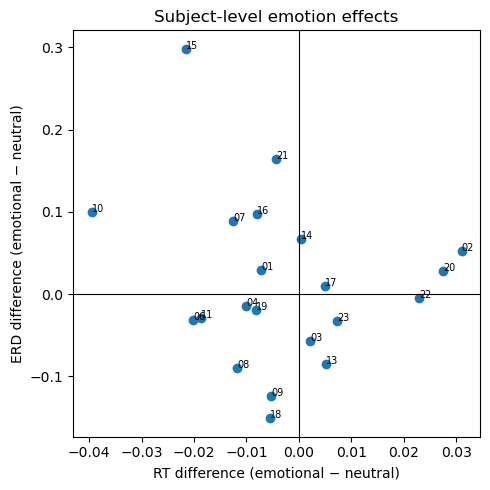

In [13]:
x = merged["rt_diff"]
y = merged["erd_diff"]

plt.figure(figsize=(5,5))
plt.scatter(x, y)

for subj, xv, yv in zip(merged.index, x, y):
    plt.text(xv, yv, subj, fontsize=7)

plt.axhline(0, color="black", linewidth=0.8)
plt.axvline(0, color="black", linewidth=0.8)

plt.xlabel("RT difference (emotional − neutral)")
plt.ylabel("ERD difference (emotional − neutral)")
plt.title("Subject-level emotion effects")

plt.tight_layout()
plt.show()

emotion    1    2
subject          
01       121  119
02        44   34
03       129  125
04       100  120
06       125  133
07       126  132
08        65   64
09       128  128
10        43   55
11       102   84
13       126  136
14       120  103
15        73   47
16        59   52
17       150  127
18        55   74
19       119  155
20       114  128
21       121  151
22        66   70
23       138  129

Total neutral trials: 2124
Total emotional trials: 2166


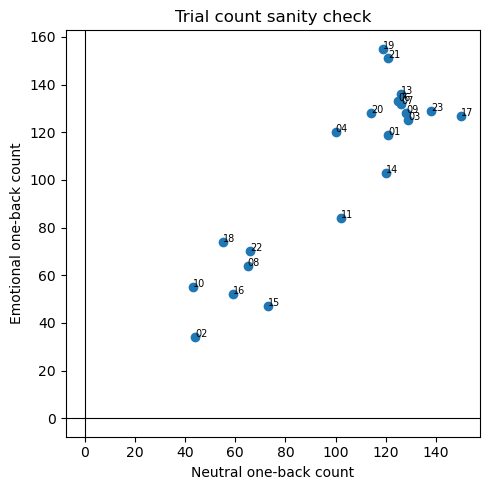

In [14]:
# per-subject event counts
counts = (
    df.groupby(["subject", "emotion"])
      .size()
      .unstack()
      .fillna(0)
      .astype(int)
)

print(counts)

# totals
print("\nTotal neutral trials:", counts[1].sum())
print("Total emotional trials:", counts[2].sum())

# scatter for imbalance
plt.figure(figsize=(5,5))
plt.scatter(counts[1], counts[2])
for subj, n_neu, n_emo in zip(counts.index, counts[1], counts[2]):
    plt.text(n_neu, n_emo, subj, fontsize=7)

plt.xlabel("Neutral one-back count")
plt.ylabel("Emotional one-back count")
plt.title("Trial count sanity check")
plt.axhline(0, color="black", linewidth=0.8)
plt.axvline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()


In [15]:
counts = (
    df.groupby(["subject", "emotion"])
      .size()
      .unstack()
      .fillna(0)
      .astype(int)
)

equalised_rows = []

for subj in df["subject"].unique():
    sub = df[df["subject"] == subj]

    n_neu = len(sub[sub["emotion"] == 1])
    n_emo = len(sub[sub["emotion"] == 2])
    n_keep = min(n_neu, n_emo)

    if n_keep == 0:
        continue

    neu_eq = sub[sub["emotion"] == 1].sample(n=n_keep, random_state=0)
    emo_eq = sub[sub["emotion"] == 2].sample(n=n_keep, random_state=0)

    equalised_rows.append(neu_eq)
    equalised_rows.append(emo_eq)

df_eq = pd.concat(equalised_rows, ignore_index=True)


In [16]:
import statsmodels.formula.api as smf

df_eq["subject"] = df_eq["subject"].astype("category")

model = smf.mixedlm(
    "rt_ms ~ alpha_erd + emotion",
    df_eq,
    groups=df_eq["subject"]
).fit()

print(model.summary())


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: rt_ms    
No. Observations: 4014    Method:             REML     
No. Groups:       21      Scale:              0.0092   
Min. group size:  68      Log-Likelihood:     3650.4946
Max. group size:  258     Converged:          Yes      
Mean group size:  191.1                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.562    0.015 37.724 0.000  0.533  0.591
alpha_erd     0.005    0.002  2.124 0.034  0.000  0.010
emotion      -0.004    0.003 -1.155 0.248 -0.009  0.002
Group Var     0.004    0.014                           



/opt/conda/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [18]:
rt_summary_eq = (
    df_eq.groupby(["subject","emotion"])["rt_ms"]
         .mean()
         .unstack()
)
rt_summary_eq["rt_diff"] = rt_summary_eq[2] - rt_summary_eq[1]

erd_summary_eq = (
    df_eq.groupby(["subject","emotion"])["alpha_erd"]
         .mean()
         .unstack()
)
erd_summary_eq["erd_diff"] = erd_summary_eq[2] - erd_summary_eq[1]

merged_eq = rt_summary_eq.join(erd_summary_eq, lsuffix="_rt", rsuffix="_erd")


/tmp/ipykernel_2375/3364742576.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_eq.groupby(["subject","emotion"])["rt_ms"]
/tmp/ipykernel_2375/3364742576.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_eq.groupby(["subject","emotion"])["alpha_erd"]


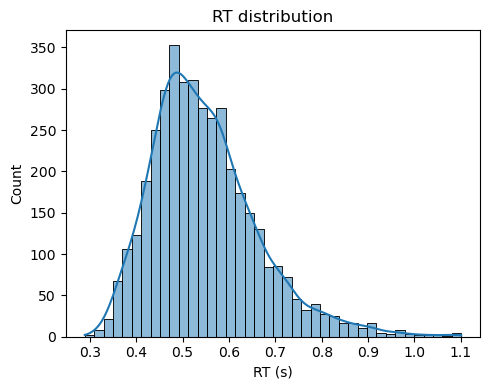

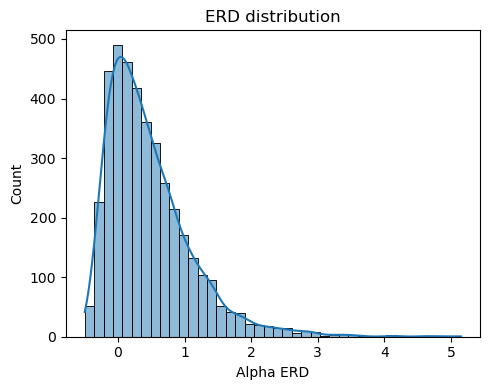

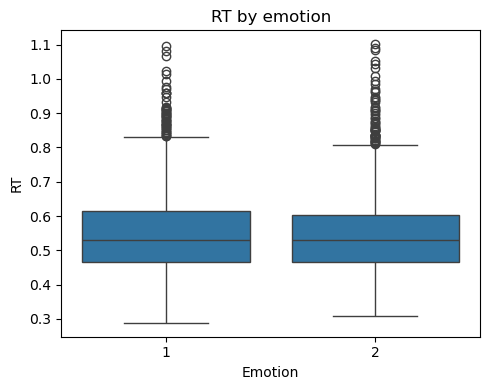

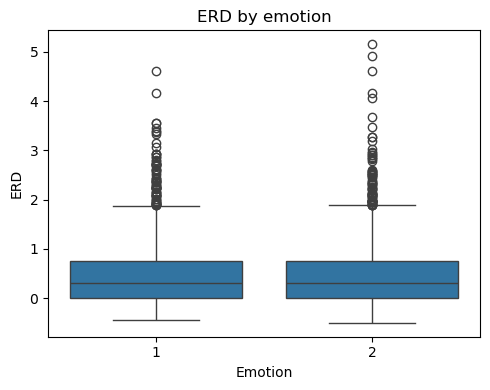

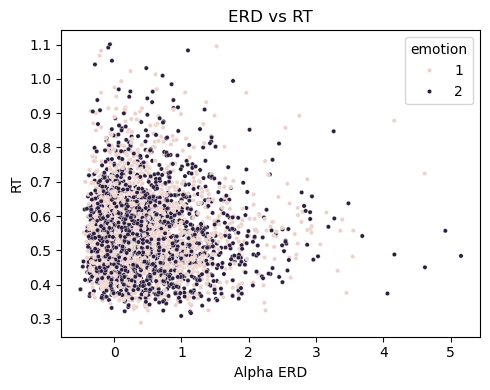

/tmp/ipykernel_2375/316585617.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subj_means = df_eq.groupby("subject")["rt_ms"].mean()


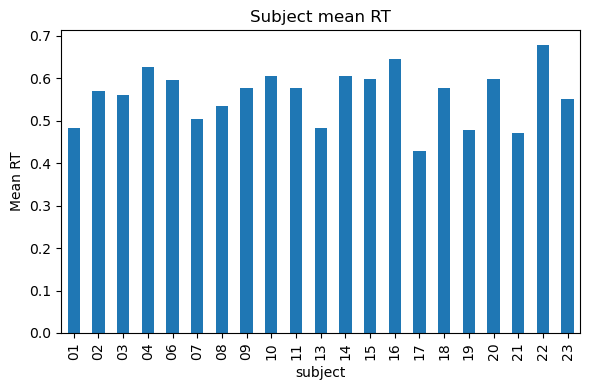

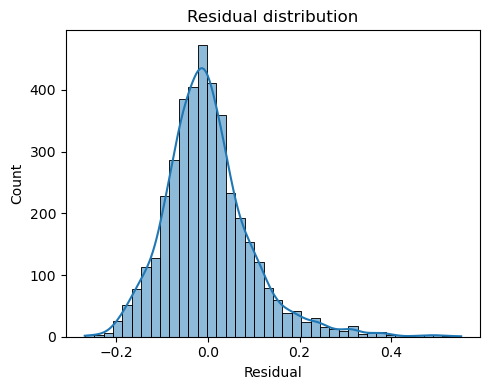

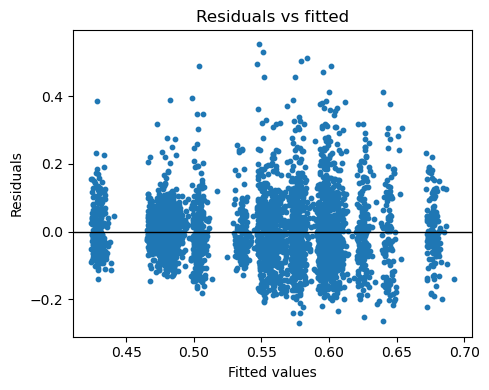

In [19]:
import seaborn as sns


# response distribution
plt.figure(figsize=(5,4))
sns.histplot(df_eq["rt_ms"], bins=40, kde=True)
plt.xlabel("RT (s)")
plt.title("RT distribution")
plt.tight_layout()
plt.show()

# predictor distribution
plt.figure(figsize=(5,4))
sns.histplot(df_eq["alpha_erd"], bins=40, kde=True)
plt.xlabel("Alpha ERD")
plt.title("ERD distribution")
plt.tight_layout()
plt.show()

# boxplot RT by emotion
plt.figure(figsize=(5,4))
sns.boxplot(data=df_eq, x="emotion", y="rt_ms")
plt.xlabel("Emotion")
plt.ylabel("RT")
plt.title("RT by emotion")
plt.tight_layout()
plt.show()

# boxplot ERD by emotion
plt.figure(figsize=(5,4))
sns.boxplot(data=df_eq, x="emotion", y="alpha_erd")
plt.xlabel("Emotion")
plt.ylabel("ERD")
plt.title("ERD by emotion")
plt.tight_layout()
plt.show()

# scatter: ERD vs RT
plt.figure(figsize=(5,4))
sns.scatterplot(data=df_eq, x="alpha_erd", y="rt_ms", hue="emotion", s=10)
plt.xlabel("Alpha ERD")
plt.ylabel("RT")
plt.title("ERD vs RT")
plt.tight_layout()
plt.show()

# subject-level random intercepts
subj_means = df_eq.groupby("subject")["rt_ms"].mean()
plt.figure(figsize=(6,4))
subj_means.plot(kind="bar")
plt.ylabel("Mean RT")
plt.title("Subject mean RT")
plt.tight_layout()
plt.show()






In [28]:
#log transform variables
# For RT (all positive) - straightforward log transform
df_eq["log_rt"] = np.log(df_eq["rt_ms"])

# For ERD with negative values, options:
# Option 1: Shift then log (if minimum is small)
df_eq["log_erd"] = np.log(df_eq["alpha_erd"] - df_eq["alpha_erd"].min() + 1)

# Option 2: Use the raw ERD but log-transform just RT
# This is often sufficient since RT is the dependent variable

# Then refit:
model = smf.mixedlm("log_rt ~ alpha_erd + emotion", df_eq, groups=df_eq["subject"]).fit()
print(model.summary())


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_rt   
No. Observations: 4014    Method:             REML     
No. Groups:       21      Scale:              0.0270   
Min. group size:  68      Log-Likelihood:     1495.9078
Max. group size:  258     Converged:          Yes      
Mean group size:  191.1                                
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   -0.598    0.027 -22.345 0.000 -0.651 -0.546
alpha_erd    0.009    0.004   2.190 0.029  0.001  0.018
emotion     -0.006    0.005  -1.063 0.288 -0.016  0.005
Group Var    0.014    0.026                            



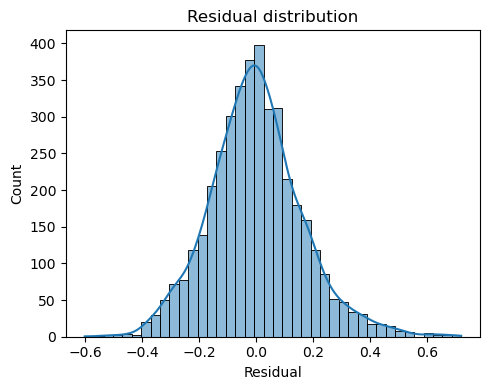

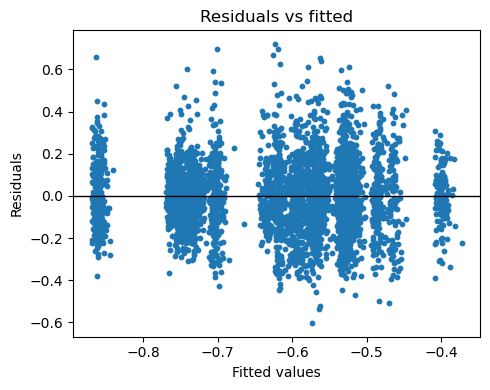

In [30]:
# residuals
pred = model.fittedvalues
resid = df_eq["log_rt"] - pred

plt.figure(figsize=(5,4))
sns.histplot(resid, bins=40, kde=True)
plt.xlabel("Residual")
plt.title("Residual distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
plt.scatter(pred, resid, s=10)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs fitted")
plt.tight_layout()
plt.show()


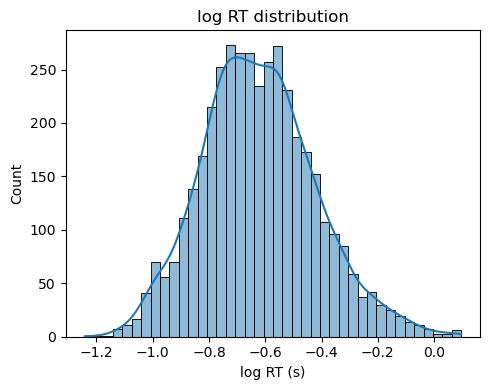

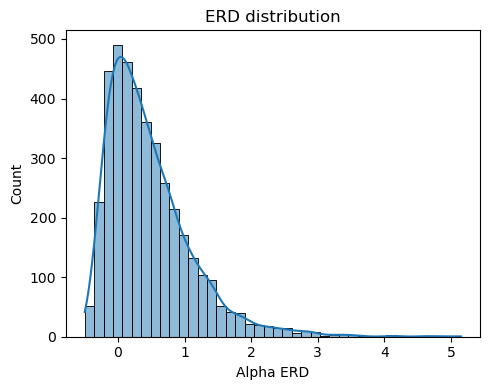

In [32]:
import seaborn as sns


# response distribution
plt.figure(figsize=(5,4))
sns.histplot(df_eq["log_rt"], bins=40, kde=True)
plt.xlabel("log RT (s)")
plt.title("log RT distribution")
plt.tight_layout()
plt.show()

# predictor distribution
plt.figure(figsize=(5,4))
sns.histplot(df_eq["alpha_erd"], bins=40, kde=True)
plt.xlabel("Alpha ERD")
plt.title("ERD distribution")
plt.tight_layout()
plt.show()

